# 6.2 Region-content description

Unlike shape description techniques, which work with regions' contours, region-content description focuses on characterizing the content of segmented regions through their distribution in the image, their textures, etc. Regarding textures, it gives us information about the spatial arrangement of color or intensities in an image or selected region of an image. Textures can be used to help in segmentation or classification of images. Notice that these methods doesn't require binary images as input. 

This notebook covers different region-content description techniques:

- 2D image moments (section 6.2.1)
- Hu moments (section 6.2.2)
- Image histogram moments (section 6.2.3.1)
- Co-ocurrence matrices (section 6.2.3.2)


## Problem context - Car plates

In this notebook, our task is twofold!

### Number-plate detection for UMA

<img src="./images/access_system.png" width="400">$\\[5pt]$

Basically, we have to continue with our number-plate detection work looking for a way to obtain a feature vector that distinguishes each character in a Spanish car plate. In this notebok we will try more advanced methods, like **image moments** or **Hu moments**.

### Identification of the State of a license plate state

An American company contacted us for developing a **texture description method** that describes **a license plate according to its State of origin** instead of the characters appearing. As you may know, USA uses a different license plates for each state in the country:$\\[5pt]$

<img src="./images/usa_plates.jpg" width="600">

You will use some region description methods applied to this problem like **co-ocurrence matrices** or **image histogram moments**. Again, your task is to develop a method returning a feature vector that allows for the identification of the State of origin of such license plates.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0, 8.0)
from scipy import stats 

images_path = './images/'

## 6.2.1 Image moments

An **image moment** (2D-moment) is weighted average (or moment) of the intensity of the pixels in the image/region, or a function combining other moments. Moments usually have some attractive property or interpretation, and they can work in both grayscale and color images. There are 3 main types of moments:

- **Non-central moments:**$\\[3pt]$

$\hspace{2cm}m_{ij} = \sum_{y=1}^{cols}\sum_{x=1}^{rows}x^i y^j I(x,y)$

- **Central moments:**

  $\hspace{1.2cm}\mu_{ij} = \sum_{y=1}^{cols}\sum_{x=1}^{rows}(x-\overline{x})^i (y-\overline{y})^j I(x,y)$ 
  $\\[2pt]$<br />
  where: <br />
    - $\left(\overline{x},\overline{y}\right) = \left(\frac{m_{10}}{m_{00}} ,\frac{m_{01}}{m_{00}} \right)$ is the centroid of the region $\\[3pt]$
    - $I(x,y)$ means the intensity of the pixel in the $(x, y)$ coordinates of image $I$.
 
  When dealing with big images/regions, it is possible to save some computation time computing the central moments using the non-central ones:

$
\hspace{2cm}\mu_{00} = m_{00} \equiv \mu \\
\hspace{2cm}\mu_{01} = 0 \\
\hspace{2cm}\mu_{10} = 0 \\
\hspace{2cm}\mu_{20} = m_{20} - \mu \overline{x}^2\\
\hspace{2cm}\mu_{11} = m_{11} - \mu \overline{xy}\\
\hspace{2cm}\mu_{02} = m_{02} - \mu \overline{y}^2\\
\hspace{2cm}\mu_{30} = m_{30} - 3m_{20} \overline{x} + 2 \mu \overline{x}^3 \\
\hspace{2cm}\mu_{21} = m_{21} - m_{20} \overline{y} - 2m_{11} \overline{x} + 2\mu \overline{x}^2\overline{y} \\
\hspace{2cm}\mu_{12} = m_{12} - m_{02} \overline{x} - 2m_{11} \overline{y} + 2\mu \overline{y}^2\overline{x}\\
\hspace{2cm}\mu_{03} = m_{03} - 3m_{02} \overline{y} + 2 \mu \overline{y}^3\\[3pt] 
$

- **Scale invariant moments:**$\\[3pt]$

$\hspace{2cm} \eta_{ij} = \mu_{ij}\ /\ \mu_{00}^{1+((i+j)/2)}$

$\hspace{2cm}$ where $i + j \ge 2$.

#### <font color="orange">OpenCV pill</font>
    
OpenCV defines a method for computing some central, non-central and scale-invariant moments called [`cv2.moments()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139), which gets:

- working with intensity images: a contour (array of 2D points) delimiting the segmented regions.
- working with grayscale images: the image itself.

This function returns a dictionary containing those moments.

### **<span style="color:green"><b><i>ASSIGNMENT 1: Computing image moments</i></b></span>**

**What to do?** Your first tasks is to complete the method `image_moments()`, which applies the previously mentioned [`cv2.moments()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139) to a binary image (e.g. thresholded numbers of a plate).

In [2]:
# Assignment 1
def image_moments(region):
    """ Compute moments of the region in a binary image.   
    
        Args:
            region: Binary image
                    
        Returns: 
            moments: dictionary containing all moments of the region
    """   
    
    # Get external contour
    contours,_ = cv2.findContours(region,cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_NONE)
    cnt = contours[0]
    
    # Compute moments
    moments = cv2.moments(cnt)
    
    return moments

You can use next code to **test if the results are correct**:

In [3]:
region = np.array([[255,255,255,255,255],[255,0,0,0,255],[255,0,0,255,255],[255,0,255,255,255],[0,0,255,255,255]], dtype=np.uint8)
moments = image_moments(region)

# Round moments for visualization matters
for k, v in moments.items():
    moments[k] = round(v,2)

print(moments)

{'m00': 5.0, 'm10': 14.67, 'm01': 12.0, 'm20': 48.17, 'm11': 37.0, 'm02': 36.17, 'm30': 163.4, 'm21': 119.17, 'm12': 111.13, 'm03': 116.0, 'mu20': 5.14, 'mu11': 1.8, 'mu02': 7.37, 'mu30': -8.07, 'mu21': -6.99, 'mu12': -3.6, 'mu03': -6.16, 'nu20': 0.21, 'nu11': 0.07, 'nu02': 0.29, 'nu30': -0.14, 'nu21': -0.13, 'nu12': -0.06, 'nu03': -0.11}


<font color='blue'>**Expected output  </font> (using `CHAIN_APPROX_NONE`):**

    {'m00': 5.0, 'm10': 14.67, 'm01': 12.0, 'm20': 48.17, 'm11': 37.0, 'm02': 36.17, 'm30': 163.4, 'm21': 119.17, 'm12': 111.13, 'm03': 116.0, 'mu20': 5.14, 'mu11': 1.8, 'mu02': 7.37, 'mu30': -8.07, 'mu21': -6.99, 'mu12': -3.6, 'mu03': -6.16, 'nu20': 0.21, 'nu11': 0.07, 'nu02': 0.29, 'nu30': -0.14, 'nu21': -0.13, 'nu12': -0.06, 'nu03': -0.11}

### Invariance analysis 

Image moments could be good descriptors for addressing the problem posed by UMA. We could compute the moments of a segment region and use them as feature vector. Also, as $i$ and $j$ in the previous equations can take any integer, we could have a feature vector of any desired length.

Our only problem is that the results have to be (at least) position and scale invariants, because a car be stopped closer or further away from the camera (rotation is not that important).

To check if these moments have such invariances, you are going to compute the moments of a scaled and rotated region. To visually check the results, we are going to use bar charts, showing the moments for the original, rotated and scaled images, which should look like this:

<img src="./images/moments.png" width="800">

### **<span style="color:green"><b><i>ASSIGNMENT 2: Checking invariances</i></b></span>**

Complete the method `compare_moments()`, which takes a list of labels for the bar chart and three lists containing the moments of a region, and its rotated and scaled versions. Then, it plots the chart bar previously showed.

For the plot you can use `plt.bar(labels,values)`, where `labels` is a list of strings (e.g. `keys` of the dictionary of moments) and `values` a list of numbers (e.g. `values` of such dictionary). 

In [4]:
# Assignment 2
def compare_moments(labels, moments, moments_rotated, moments_scaled):
    """ Plot a bar chart comparing the three input moment arrays  
    
        Args:
            labels: Labels of the bar chart
            moments: list containing moments of a original region
            moments_rotated: list containing moments of the original region, but previously rotated
            moments_scaled: list containing moments of the original region, but previously scaled
    """ 
    
    # Show original moments
    plt.subplot(131)
    plt.title("Original")
    plt.bar(labels,moments)

    # Show rotated moments
    plt.subplot(132)
    plt.title("Rotated")
    plt.bar(labels,moments_rotated)

    # Show scaled moments
    plt.subplot(133)
    plt.title("Scaled")
    plt.bar(labels,moments_scaled) 

We are going to separately analyze the invariance of the the **non-central** (first 10 values of moment dictionary), **central** (following 7) and **scale-invariant** (last 7) moments.

Let's start with the **Non-central moments**.

*Hint: You can rotate a numpy array using [np.rot90](https://docs.scipy.org/doc/numpy/reference/generated/numpy.rot90.html) and scale an image using [cv2.resize](https://docs.opencv.org/4.2.0/da/d54/group__imgproc__transform.html#ga47a974309e9102f5f08231edc7e7529d), although there are many more options.*

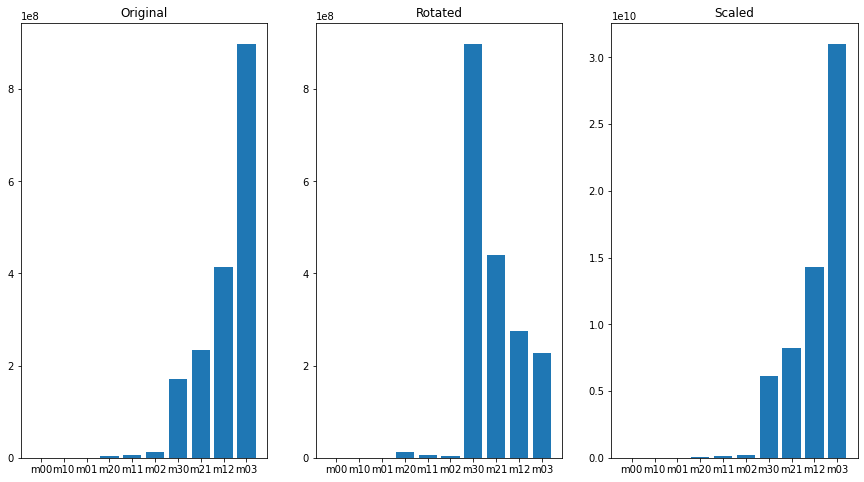

In [5]:
# Read binary image and compute moments
region = cv2.imread(images_path + 'region_6.png',0)
moments = image_moments(region)

# Rotate image and compute moments
region_rotated = np.rot90(region)
moments_rotated = image_moments(region_rotated)

# Resize image and compute moments
region_scaled = cv2.resize(region, dsize=None, fx=2, fy=2)
moments_scaled = image_moments(region_scaled)

# Compare results for non-central moments
labels = list(moments.keys())[:10]
non_central_moments = list(moments.values())[:10]
non_central_rotated = list(moments_rotated.values())[:10]
non_central_scaled = list(moments_scaled.values())[:10]

compare_moments(labels,non_central_moments,non_central_rotated,non_central_scaled)

### <font color="blue"><b><i>Thinking about it (1)</i></b></font>

Now, **answer the following questions:**

- Are these moments invariant to rotation?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Are these moments invariant to scale?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>   

Let's continue with **central moments**!

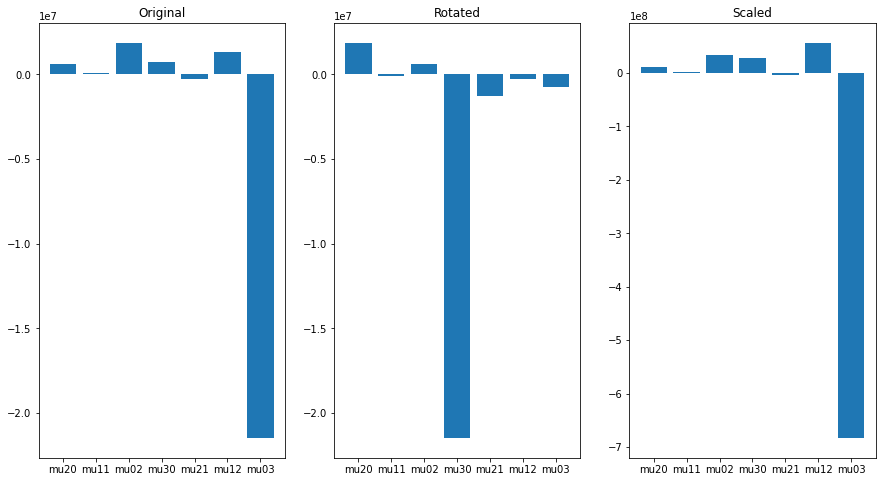

In [6]:
# Compare results for central moments

labels = list(moments.keys())[10:17]
central_moments = list(moments.values())[10:17]
central_rotated = list(moments_rotated.values())[10:17]
central_scaled = list(moments_scaled.values())[10:17]

compare_moments(labels,central_moments,central_rotated,central_scaled)

### <font color="blue"><b><i>Thinking about it (2)</i></b></font>

Now, **answer the following questions:**

- Are these moments invariant to rotation?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Are these moments invariant to scale?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  

And we conclude with **scale-invariant moments**.

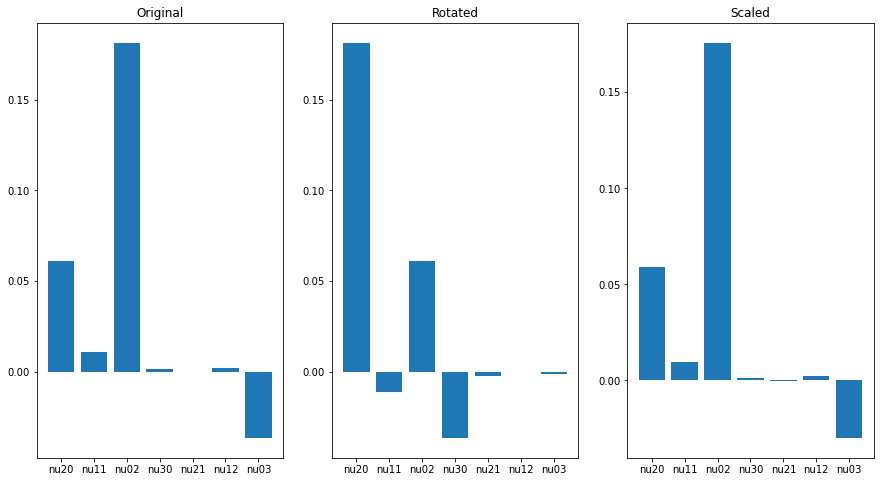

In [7]:
# Compare results for scale-invariant moments

labels = list(moments.keys())[17:]
invariant_moments = list(moments.values())[17:]
invariant_rotated = list(moments_rotated.values())[17:]
invariant_scaled = list(moments_scaled.values())[17:]

compare_moments(labels,invariant_moments,invariant_rotated,invariant_scaled)

### <font color="blue"><b><i>Thinking about it (3)</i></b></font>

Now, **answer the following questions:**

- Are these moments invariant to rotation?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Are these moments invariant to scale?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  

## 6.2.2 Hu moments

**Hu moments** (published in 1962 by Ming-Kuei Hu) are a set of 7 particular moments calculated using scale-invariant. Concretely, they are computed using following equations:

$
\hspace{2cm}v_{1} = \eta_{20} + \eta_{02} \\
\hspace{2cm}v_{2} = (\eta_{20} - \eta_{02}) + 4\eta_{11}^2 \\
\hspace{2cm}v_{3} = (\eta_{20} - 3\eta_{12})^2 + (3\eta_{21} - \eta_{03})^2 \\
\hspace{2cm}v_{4} = (\eta_{30} + \eta_{12})^2 + (\eta_{21} + \eta_{03})^2\\
\hspace{2cm}v_{5} = (\eta_{30}-3\eta_{12})(\eta_{30}+\eta_{12})[(\eta_{30}+\eta_{12})^2 -3(\eta_{21}+\eta_{03})^2] + (3\eta_{21}-\eta_{03})(\eta_{21}+\eta_{03})[3(\eta_{30}+\eta_{12})^2-(\eta_{21} + \eta_{03})^2]\\
\hspace{2cm}v_{6} = (\eta_{20}-\eta_{02})[(\eta_{30}+\eta_{12})^2 -(\eta_{21}-\eta_{03})^2 + 4\eta_{11} (\eta_{30}+\eta_{12})(\eta_{21}+\eta_{03})] \\
\hspace{2cm}v_{7} = (3\eta_{21}-\eta_{03})(\eta_{30}+\eta_{12})[(\eta_{30}+\eta_{12})^2-3(\eta_{30}+\eta_{12})^2]+(\eta_{30}-3\eta_{12})(\eta_{21}+\eta_{03})[3(\eta_{30}+\eta_{12})^2-(\eta_{21}+\eta_{03})^2]\\
$

#### <font color="orange">OpenCV pill</font>

OpenCV provides a method to retrieve the Hu moments, called (wait for it...) [`cv2.moments()`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga556a180f43cab22649c23ada36a8a139)!. This method takes as input the dictionary of moments returned by `cv2.moments`. Recall that the scale-invariant moments used for their computation are the `nuij` moments in the dictionary.

### **<span style="color:green"><b><i>ASSIGNMENT 3: Exploring Hu moments invariances</i></b></span>**

Previously, we tested the invariances of non-central, central and scale-invariant moments. Now, **we are interested in checking the invariances of the Hu moments**, so we can verify if they are more suitable for the UMA parking problem. 

For that, use your brand-new `compare_moments()` function in the same way as in the previous exercises.

[[0.68053276]
 [0.28737167]
 [0.11573529]
 [0.02576429]
 [0.00070064]
 [0.0047878 ]
 [0.00122002]]


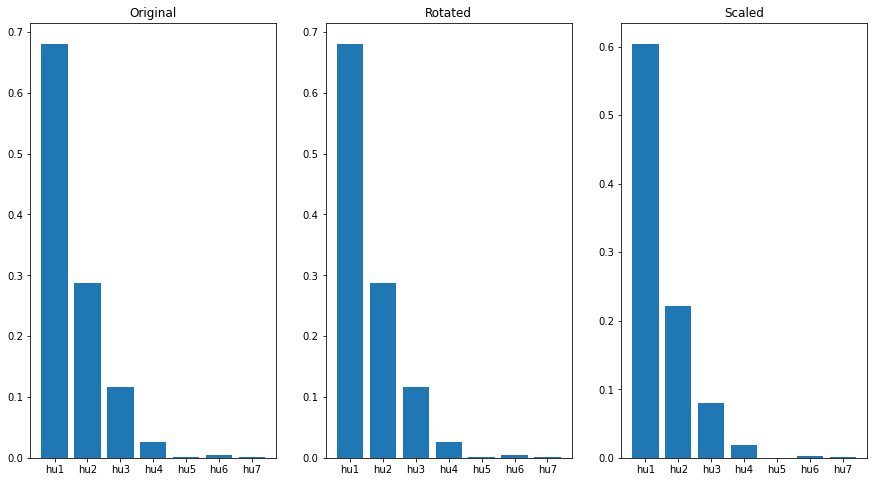

In [8]:
# Assignment 3

# Read binary image and compute Hu moments
region = cv2.imread(images_path + 'region_J.png',0)
moments = image_moments(region)
hu = cv2.HuMoments(moments)
print(hu)

# Rotate image and compute Hu moments
region = np.rot90(region)
moments_rotated = image_moments(region)
hu_rotated = cv2.HuMoments(moments_rotated)

# Resize image and compute Hu moments
region = cv2.resize(region, dsize=None, fx=2, fy=2)
moments_scaled = image_moments(region)
hu_scaled = cv2.HuMoments(moments_scaled)


# Compare results for Hu moments

labels = ["hu1","hu2","hu3","hu4","hu5","hu6","hu7"]
hu_moments = hu.flatten()
hu_rotated = hu_rotated.flatten()
hu_scaled = hu_scaled.flatten()

compare_moments(labels,hu_moments,hu_rotated,hu_scaled)

### <font color="blue"><b><i>Thinking about it (4)</i></b></font>

Now, **answer the following questions:**

- Are these moments invariant to rotation?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- Are these moments invariant to scale?

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>  
    
- Now that you can deal with different ways to describe a binary region, **what method would you use** for the UMA parking problem? **Why?**

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p> 

## 6.2.3 Texture

While the previous techniques are useful for describing the distribution of the regions over the image. There is another brunch of algorithms that pursuit the description of regions by **characterizing the texture of the pixels they enclose**. Such methods measure the spatial arrangement of the colors/intensities in a region, providing information about their smoothness, coarseness, and regularity. In this way, if a region does not present changes in intensity, we say that it is a untextured region.

<img src="./images/examples_of_different_textures.png" width="700"/>

Usually, texture descriptors have spatial (position, orientation and scale) and radiometric (contrast and brightness) invariance.

- 1D moments of the histogram, and
- Gray Level Co-Occurrence Matrix (GLCM)

### 6.2.3.1 1D moments of histogram

The **central moments of the histogram** of the pixels within the region statistically describes the frequency of their intensities. They permit us to compactly describe the region through a feature vector containing a few features. They are computed using the equation: $\\[5pt]$

$\hspace{2cm} \mu_n = \sum_{i=0}^{255} (z_i - \overline{z})^n h(z_i)$

where $h(z_i)$ represents the value stored in the histogram $h(\cdot)$ for the intensity $z_i$. Keep in mind that:

$
\hspace{2cm} \mu_0=\mu_1=0 \\ 
\hspace{2cm} \mu_2: \text{variance (contrast)} \\
\hspace{2cm} \mu_3: \text{histogram (skew)} \\
\hspace{2cm} \mu_4: \text{histogram uniformity} \\
$

However, they have a serious drawback: they don't encode pattern structures, so different textures may have similar histograms:

<img src="./images/patterns.png" width="800"/>

Nevertheless, they can be a good option depending on the application, so do not underestimate them!

### **<span style="color:green"><b><i>ASSIGNMENT 4: Analyizing histograms</i></b></span>**

In order to play a bit with these moments, we move to our second application: the state recognition in USA car plates. Two examples of such license plates: $\\[5pt]$

<img src="./images/idaho.jpg" width="300" align="left"/>
<img src="./images/nevada.jpg" width="300" align="rigth"/> $\\[5pt]$

As we can see, the main difference between them is the texture in the plate background, as each state has a different one. Let's try 1D moments of the histogram for describing those textures!

**Your first task** is to plot the histogram of the previous images: `nevada.jpg` and `hawaii.jpg`, and comment if you think that the shape of the histograms is enough to differentiate them.

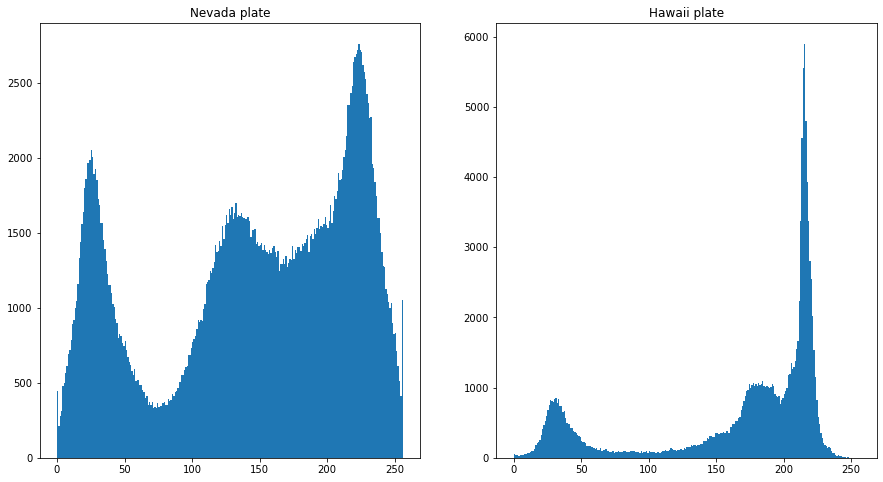

In [9]:
# Assignment 4

# Read images
nevada = cv2.imread(images_path + 'nevada.jpg',0)
hawaii = cv2.imread(images_path + 'hawaii.jpg',0)

# Show first one histogram
plt.subplot(121)
plt.title("Nevada plate")
plt.hist(nevada.ravel(),256,[0,256]) 

# And the second one!
plt.subplot(122)
plt.title("Hawaii plate")
plt.hist(hawaii.ravel(),256,[0,256]) 
plt.show() 

Now, let's complete the method `histogram_moments()` that implements the equation computing the central moments of the histogram shown above. This method takes as input:

- an image, and 
- the number of moments to be calculated

and returns an array containing those moments of the image's histogram.

*Tip: the 1D central moment of order `k` can be calculed using [`stats.moment()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.moment.html) (although it is easy to get them from scratch)*

In [10]:
def histogram_moments(image,k):
    """ Compute central moments of the histogram of an image.   
    
        Args:
            image: input image
            k: number of moments to compute
                    
        Returns: 
            histogram_moments: array containing the histogram moments
    """   
    
    
    # Compute histogram
    hist = cv2.calcHist([image],[0],None,[256],[0,256])

    # Compute moments
    histogram_moments = np.zeros(k)
    for i in range(k):
        histogram_moments[i] = stats.moment(hist, moment = i, axis = None)
        
    return(histogram_moments)

You can use the next code to **test if the results are correct**:

In [11]:
image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

moments = histogram_moments(image,6)

print(moments)

[1.         0.         0.04173279 0.05414879 0.08191809 0.13725665]


<font color='blue'>**Expected output: </font>**

    [1.  0.  0.04173279  0.05414879  0.08191809  0.13725665]

#### Invariance analysis

Now that we can obtain the first `k` moments of an image histogram, we are going to see if this method is invariant to scale and rotation. As in the UMA parking problem, our solution must be scale invariant, so let's check if it is.

### **<span style="color:green"><b><i>ASSIGNMENT 5: Checking the invariance of 1D moments</i></b></span>**

**What to do?** Check if **the first six 1D moments** of the histogram of an image, a rotated version of it, and a scaled version, are the same. Use [`np.array_equal()`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array_equal.html) for that.

In [12]:
# Assignment 5

# Read image and compute histogram moments
image = cv2.imread(images_path + 'hawaii.jpg',0)
moments = histogram_moments(image,6)

# Rotate image and compute histogram moments
image_rotated = np.rot90(image)
moments_rotated = histogram_moments(image_rotated,6)
    
# Resize image and compute histogram moments
image_scaled = cv2.resize(image, dsize=None, fx=2, fy=2)
moments_scaled = histogram_moments(image_scaled,6)

# Compare results
print("Rotation invariance: ", np.array_equal(moments,moments_rotated))
print("Scale invariance: ", np.array_equal(moments,moments_scaled))

Rotation invariance:  True
Scale invariance:  False


### <font color="blue"><b><i>Thinking about it (5)</i></b></font>

Now, **answer the following questions:**

- **It is invariant to rotation?** If not, how can we turn this method into it?

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>
    
- It is invariant to scale? **If not, how can we turn this method into it?**

    <p style="margin: 4px 0px 0px 5px; color:blue"><i>Your answer here!</i></p>

### 6.2.3.2 Co-ocurrence matrix

Another technique also obtaining a statistical representation of the texture within a region is the **co-ocurrence matrix**, a square matrix $A(i,j)$ in which:

- $i$ and $j$ represent intensity values (e.g. 0 to 255). 
- The entry $a_{ij}$ indicates how many times the intensity $i$ co-occurs with intensity $j$ in some designated spatial relationships $P$ (texture pattern). 
- $P$ is given by a displacement vector $d = [dr, dc]$, where $dr$ and $dc$ are the displacement in rows and columns, respectively.

<img src="./images/co-ocu.png" width="650"/>

The issue with this approach is how to select the appropriate displacement $d$. Once the co-ocurrence matrix of a region has been computed, a number of features can be extracted from it:

- **Maximum probability:** gives us the strongest response to the texture pattern $P$$ \\[1pt]$

$\hspace{2cm} max_{ij}\ c_{ij}$

- **Energy:** mínimum when all the entries $c_{ij}$ are identical (máximum uniformity)$ \\[1pt]$

$\hspace{2cm} \sum_{i=0}^{255}\sum_{j=0}^{255}\ c_{ij}^2$

- **Entropy:** measure randomness. Maximum value when all the entries $c_{ij}$ are identical (máximum entropy  $\rightarrow$ mínimum mínima energía)$ \\[1pt]$

$\hspace{2cm} -\sum_{i=0}^{255}\sum_{j=0}^{255}\ c_{ij} \ logc_{ij}$

- **Order k central moment**$ \\[1pt]$

$\hspace{2cm} \sum_{i=0}^{255}\sum_{j=0}^{255}\ (i-j)^k \ c_{ij}$

### **<span style="color:green"><b><i>ASSIGNMENT 6: Computing co-ocurrence matrices</i></b></span>**

Let's implement the method `co_ocurrence_matrix_features()`, which has to compute the normalized co-ocurrence matrix of `image` using the displacement vector `[dr,dc]` and normalizes it, obtaining `C(i,j)`. Note that `dr` and `dc` may take positive or negative values. Thereby, it takes as inputs:
- an image, 
- a 2-size displacement vector, and 
- a number of central moment to compute. 

and returns:
- a feature vector with size 3 + `n_moments` being: [`max_prob`, `energy`, `entropy`, `moments` (optional)]

In [13]:
# Assignment 6

def co_ocurrence_matrix_features(image, d, n_moments):
    """ Compute features from a image using a co-ocurrence matrix.   
    
        Args:
            image: Binary image
            d: displacement vector
            n_moments: number of moment to be computed
                    
        Returns: 
            features: feature vector
    """   
    
    (n_r, n_c) = image.shape
    co = np.zeros((256,256))
    features = np.zeros(3+n_moments)
    
    # Compute image ranges to iterate from displacement vector
    
    if d[0] >= 0:
        range_rows = range(0, n_r-d[0], 1)
    else:
        range_rows = range(-d[0], n_r, 1)

    if d[1] >= 0:
        range_columns = range(0, n_c-d[1], 1)
    else:
        range_columns = range(-d[1], n_c, 1)

    # Compute co-ocurrence matrix    
    for r in range_rows:
        for c in range_columns:

            i = image[r,c]
            j = image[r+d[0],c+d[1]]

            co[i,j] += 1

    # Normalize co-ocurrence matrix
    co = co/np.sum(co)

    # Maximum probability
    features[0] = np.max(co)

    # Energy
    features[1] = np.sum(np.square(co), axis=None)

    # Entropy
    mask = np.where(co!=0, True, False)
    features[2] = -np.sum(np.multiply(co,np.log(co, where=mask)), axis=None)

    # Central moments
    for k in range(n_moments):
        moment = 0
        for i in range(co.shape[0]):
            for j in range(co.shape[1]):
                moment += ((i-j)**k)*co[i,j]
                
        features[3+k] = moment
        
    return np.round(features,3)

You can use the next code to **test if the results are right**:

In [14]:
np.set_printoptions(suppress=True)

image = np.array([[10,60,20],[60,22,74],[72,132,2]], dtype=np.uint8)

features = co_ocurrence_matrix_features(image,d=[1,-2],n_moments=4)

print(features)

[     0.5        0.5        0.693      1.       -19.       802.
 -31996.   ]


<font color='blue'>**Expected output: </font>**

    [0.5  0.5  0.693  1.  -19.  802.  -31996.  ]

### **<span style="color:green"><b><i>ASSIGNMENT 7: Studying the invariance of co-occurence matrices</i></b></span>**

Compare the results returned by `co_ocurrence_matrix_features()` when using the original image `hawaii.jpg`, with those returned by a rotated or scaled version of it.

In [15]:
# Assignment 7

# Read image and compute co-occurence matrix features
image = cv2.imread(images_path + 'hawaii.jpg',0)
features = co_ocurrence_matrix_features(image,d=[1,-2],n_moments=4)

# Rotate image and compute co-occurence matrix features
image = np.rot90(image)
features_rotated = co_ocurrence_matrix_features(image,d=[1,-2],n_moments=4)
    
# Resize image and compute co-occurence matrix features
image = cv2.resize(image, dsize=None, fx=2, fy=2)
features_scaled = co_ocurrence_matrix_features(image,d=[1,-2],n_moments=4)

# Compare results
print("Features original ", features,"\n Features rotated ", features_rotated, "\n Features scaled ", features_scaled)

Features original  [    0.012     0.001     8.25      1.       -0.16   1351.08  -3613.806] 
 Features rotated  [     0.012      0.001      8.247      1.        -0.526   1226.847
 -12101.767] 
 Features scaled  [    0.018     0.002     7.801     1.       -0.247   320.929 -1558.827]


### <font color="blue"><b><i>Thinking about it (6)</i></b></font>

Now, **answer the following question:**

- **Compare the invariance of each feature in the feature vector** and **comment why it is invariant or not to rotation and scale.**

    <p style="margin: 4px 0px 6px 5px; color:blue"><i>Your answer here!</i></p>

## Conclusion

Awesome! This was a laborious and dense notebook, but you carried it through to the end!

In this notebook you have learned:

- how to compute non-central, central, scale-invariant and Hu moments for describing a region, and apply them to the plate number recognition problem.

- how to describe textures using 1D moments of the histogram and co-ocurrence matrices, using them in the context of the state identification problem.

## Extra

Usually, the co-ocurrence matrices **of the image rotated** 45, 90, and 135 degrees are also calculated. **What do you think this is due to?**  

**Implement this new procedure** for co-ocurrence matrices and then, check again the invariances. **What happened?**